In [ ]:
! pip install lifelines
import lifelines
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from lifelines import CoxPHFitter

In [ ]:
sepsis_all_df = pd.read_csv("/content/data_all.csv")
sepsis_all_df.info()
sepsis_all_df.describe().to_csv("/content/data_summary.csv")
try :
  sepsis_all_df.drop('time_to_death',  axis=1, inplace=True)
except :
  pass
sepsis_all_df.insert(57, column="time_to_death",value=None)
sepsis_all_df_copy = sepsis_all_df.copy(deep=True)
format = '%Y-%m-%d %H:%M:%S'
for i in range(sepsis_all_df.shape[0]):
  if sepsis_all_df["death_flag"][i] == 1 and type(sepsis_all_df["death_time"][i]) is str:
    time_diff = datetime.strptime(sepsis_all_df["death_time"][i],format) - datetime.strptime(sepsis_all_df["sofa_time"][i],format)
    time_diff_in_days = time_diff.total_seconds()/(360*24)
    sepsis_all_df_copy["time_to_death"][i] = time_diff_in_days
    # print(row["time_to_death"])
  else:
    time_diff = datetime.strptime(sepsis_all_df["dischtime"][i],format) - datetime.strptime(sepsis_all_df["sofa_time"][i],format)
    time_diff_in_days = time_diff.total_seconds()/(360*24)
    sepsis_all_df_copy["time_to_death"][i] = time_diff_in_days
    # print(row["time_to_death"])
  if sepsis_all_df["gender"][i] == 'M':
    sepsis_all_df_copy["gender"][i] = 0
  else:
    sepsis_all_df_copy["gender"][i] = 1
sepsis_all_df_non_neg = sepsis_all_df_copy[sepsis_all_df_copy["time_to_death"]>=0]
sepsis_all_df_non_neg.info()
dropColList = ["rn_charttime",
              "rn_sofa_stay",
              "sofa_time", 
              "charttime", 
              "antibiotic_time", 
              "culture_time",
              "suspected_infection_time",
              "death_time",
              "subject_id",
              "stay_id",
              "admittime",
              "dischtime",
              "Unnamed: 0",
              "Unnamed: 0.1",
              "subject_id_1",
              "stay_id_1",
              "hadm_id",
              "sepsis3",
              "respiration",
              "coagulation",
              "cardiovascular",
              "renal",
              "cns",
              "liver",
              "mbp"]

for entry in dropColList:
  sepsis_all_df_non_neg = sepsis_all_df_non_neg.drop(entry, axis=1)

sepsis_all_df_non_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27139 entries, 0 to 27138
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                27139 non-null  int64  
 1   subject_id                27139 non-null  int64  
 2   stay_id                   27139 non-null  int64  
 3   antibiotic_time           27139 non-null  object 
 4   culture_time              27139 non-null  object 
 5   suspected_infection_time  27139 non-null  object 
 6   sofa_time                 27139 non-null  object 
 7   pao2fio2ratio_novent      27139 non-null  float64
 8   pao2fio2ratio_vent        27139 non-null  float64
 9   rate_dobutamine           27139 non-null  float64
 10  rate_epinephrine          27139 non-null  float64
 11  rate_norepinephrine       27139 non-null  float64
 12  rate_dopamine             27139 non-null  float64
 13  meanbp_min                27139 non-null  float64
 14  gcs_mi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to b

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27118 entries, 0 to 27138
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                27118 non-null  int64  
 1   subject_id                27118 non-null  int64  
 2   stay_id                   27118 non-null  int64  
 3   antibiotic_time           27118 non-null  object 
 4   culture_time              27118 non-null  object 
 5   suspected_infection_time  27118 non-null  object 
 6   sofa_time                 27118 non-null  object 
 7   pao2fio2ratio_novent      27118 non-null  float64
 8   pao2fio2ratio_vent        27118 non-null  float64
 9   rate_dobutamine           27118 non-null  float64
 10  rate_epinephrine          27118 non-null  float64
 11  rate_norepinephrine       27118 non-null  float64
 12  rate_dopamine             27118 non-null  float64
 13  meanbp_min                27118 non-null  float64
 14  gcs_mi

In [ ]:
sepsis_Y = sepsis_all_df_non_neg["time_to_death"]
sepsis_X = sepsis_all_df_non_neg.drop("time_to_death", axis=1)
sepsis_X.isna().sum()
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( sepsis_X, sepsis_Y, test_size=0.20, random_state=42)
trainData = [X_train, y_train]
trainData = pd.concat(trainData, axis = 1)
trainData.to_csv("/content/sepsisTrainData_15May.csv")
testData = [X_test, y_test]
testData = pd.concat(testData, axis =1)
testData.to_csv("/content/sepsisTestData_15May.csv")

In [ ]:
trainData.shape

(21694, 33)

In [ ]:
testData.shape

(5424, 33)

In [ ]:
testData.info()

In [ ]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21694 entries, 1289 to 23673
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pao2fio2ratio_novent  21694 non-null  float64
 1   pao2fio2ratio_vent    21694 non-null  float64
 2   rate_dobutamine       21694 non-null  float64
 3   rate_epinephrine      21694 non-null  float64
 4   rate_norepinephrine   21694 non-null  float64
 5   rate_dopamine         21694 non-null  float64
 6   meanbp_min            21694 non-null  float64
 7   gcs_min               21694 non-null  float64
 8   uo_24hr               21694 non-null  float64
 9   bilirubin_max         21694 non-null  float64
 10  creatinine_max        21694 non-null  float64
 11  platelet_min          21694 non-null  float64
 12  sofa_score            21694 non-null  int64  
 13  death_flag            21694 non-null  int64  
 14  heart_rate            21694 non-null  float64
 15  sbp             

In [ ]:
trainData["gender"].head()

1289     0
18244    1
13780    1
23425    1
5103     0
Name: gender, dtype: object

In [ ]:
trainData["time_to_death"][trainData["time_to_death"] < 0]

Series([], Name: time_to_death, dtype: object)

In [ ]:
trainData.corr()

,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_dobutamine,rate_epinephrine,rate_norepinephrine,rate_dopamine,meanbp_min,gcs_min,uo_24hr,bilirubin_max,creatinine_max,platelet_min,sofa_score,death_flag,heart_rate,sbp,dbp,sbp_ni,mbp_ni,dbp_ni,temperature,glucose,spo2,resp_rate,los_hospital,admission_age,hospstay_seq,first_hosp_stay,ICULOS,icustay_seq,first_icu_stay
pao2fio2ratio_novent,1.000000,0.175264,-0.011832,-0.014161,-0.067609,-0.027672,-0.020611,-0.009840,-0.011882,-0.017039,0.032644,-0.049865,-0.053844,-0.069428,-0.068063,-0.019044,-0.010442,-0.024223,-0.014668,-0.018170,-0.033746,-0.002841,0.084130,-0.090757,-0.125531,0.021849,0.027472,-0.047292,-0.252782,-0.063016,0.062250
pao2fio2ratio_vent,0.175264,1.000000,-0.058992,-0.108599,-0.250046,-0.046125,0.033556,-0.083860,0.028430,-0.046411,0.001797,0.004926,-0.267102,-0.159069,-0.042640,0.038775,0.029972,0.016087,-0.000689,-0.007183,-0.046194,-0.008825,0.024677,-0.049501,-0.102748,0.084904,0.052849,-0.073662,-0.283580,-0.034735,0.038799
rate_dobutamine,-0.011832,-0.058992,1.000000,0.067251,0.162807,0.052407,-0.029204,0.015771,-0.003194,0.016429,0.057167,-0.024377,0.102761,0.077665,0.025953,-0.060640,-0.015012,-0.056068,-0.030080,-0.011861,-0.019248,-0.002216,-0.034632,0.032561,0.014950,0.012151,0.005849,-0.013145,0.060564,0.009345,-0.015984
rate_epinephrine,-0.014161,-0.108599,0.067251,1.000000,0.249760,0.057980,-0.043387,0.012593,-0.026158,0.022020,0.045375,-0.034554,0.130462,0.114274,0.048868,-0.060593,-0.038031,-0.047363,-0.030822,-0.023302,-0.051370,0.002556,-0.070397,0.046070,-0.012286,-0.016954,-0.003447,0.007149,0.009044,0.033049,-0.026201
rate_norepinephrine,-0.067609,-0.250046,0.162807,0.249760,1.000000,0.132485,-0.124607,0.061725,-0.085010,0.106460,0.132429,-0.018934,0.340534,0.258262,0.156556,-0.172683,-0.078018,-0.166872,-0.103482,-0.061715,-0.044762,0.020931,-0.133220,0.153665,0.038705,0.000810,0.020177,-0.033545,0.124237,0.033909,-0.032804
rate_dopamine,-0.027672,-0.046125,0.052407,0.057980,0.132485,1.000000,-0.036556,0.012709,-0.019073,-0.000432,0.038763,0.009767,0.055843,0.061030,-0.005109,-0.031929,-0.027998,-0.027617,-0.033484,-0.031279,-0.045646,-0.000463,-0.062429,0.021033,-0.017388,0.020197,-0.004833,0.003336,0.012645,-0.007687,0.008574
meanbp_min,-0.020611,0.033556,-0.029204,-0.043387,-0.124607,-0.036556,1.000000,-0.084402,0.048573,-0.022479,0.004672,0.013824,-0.112604,-0.033024,0.094833,0.535077,0.631499,0.459594,0.611459,0.567591,0.101161,-0.008843,-0.015401,0.064295,0.041333,-0.119794,0.003778,0.011506,0.045605,-0.015940,0.012976
gcs_min,-0.009840,-0.083860,0.015771,0.012593,0.061725,0.012709,-0.084402,1.000000,-0.004463,0.016000,0.047715,-0.048700,-0.155820,-0.028993,-0.008546,-0.084811,-0.063394,-0.072549,-0.057110,-0.044605,0.001430,0.006923,-0.013934,-0.006586,-0.013111,-0.059294,-0.006313,0.011521,0.005340,-0.018339,0.019655
uo_24hr,-0.011882,0.028430,-0.003194,-0.026158,-0.085010,-0.019073,0.048573,-0.004463,1.000000,-0.105698,-0.127315,0.021452,-0.106728,-0.146459,-0.005789,0.052016,0.078143,0.040612,0.066365,0.078496,0.048107,-0.016911,0.046441,-0.041933,-0.031784,-0.166199,-0.037878,0.042117,-0.054565,-0.039522,0.038758
bilirubin_max,-0.017039,-0.046411,0.016429,0.022020,0.106460,-0.000432,-0.022479,0.016000,-0.105698,1.000000,0.106740,-0.169310,0.354446,0.150161,0.061551,-0.067175,-0.038775,-0.068652,-0.051050,-0.035577,-0.038936,0.056356,-0.039534,0.033127,0.088124,-0.111070,-0.015726,0.010760,0.063146,0.081874,-0.077229


In [ ]:
cph = CoxPHFitter(l1_ratio=0.5)
cph.fit(trainData, duration_col='time_to_death', event_col='death_flag',show_progress=True, step_size=0.1)
cph.print_summary()

Iteration 1: norm_delta = 1.09488, step_size = 0.1000, log_lik = -25078.61722, newton_decrement = 1803.30650, seconds_since_start = 0.6
Iteration 2: norm_delta = 0.80102, step_size = 0.1000, log_lik = -24737.82566, newton_decrement = 1260.40656, seconds_since_start = 1.1
Iteration 3: norm_delta = 0.81012, step_size = 0.1000, log_lik = -24498.14467, newton_decrement = 1158.76834, seconds_since_start = 1.7
Iteration 4: norm_delta = 0.87829, step_size = 0.0980, log_lik = -24281.71818, newton_decrement = 1083.23163, seconds_since_start = 2.3
Iteration 5: norm_delta = 0.94598, step_size = 0.0960, log_lik = -24083.32196, newton_decrement = 992.27375, seconds_since_start = 2.8
Iteration 6: norm_delta = 1.00215, step_size = 0.0941, log_lik = -23905.06544, newton_decrement = 902.81757, seconds_since_start = 3.4
Iteration 7: norm_delta = 1.04818, step_size = 0.0922, log_lik = -23745.98471, newton_decrement = 819.61168, seconds_since_start = 4.0
Iteration 8: norm_delta = 1.08850, step_size = 0.09

<lifelines.CoxPHFitter: fitted with 21694 total observations, 18935 right-censored observations>
             duration col = 'time_to_death'
                event col = 'death_flag'
      baseline estimation = breslow
   number of observations = 21694
number of events observed = 2759
   partial log-likelihood = -22468.02
         time fit was run = 2021-05-16 17:13:42 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
pao2fio2ratio_novent  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
pao2fio2ratio_vent    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
rate_dobutamine        0.04       1.04       0.02             0.00             0.07                 1.00                 1.07
rate_epinephrine       1.57       4.79       0.18             1.22             1.92                 3.38                 6.80
rate_norepinephrine    1.73       5.63       0.08             1.57             1.89                 4.78                 6.62
rate_dopamine          0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
meanbp_min             0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
gcs_min               -0.07       0.93       0.01            -0.08            -0.05                 0.92                 0.95
uo_24hr               -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
bilirubin_max          0.05       1.05       0.00             0.04             0.05                 1.04                 1.05
creatinine_max         0.05       1.05       0.01             0.03             0.08                 1.03                 1.08
platelet_min           0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
sofa_score             0.04       1.04       0.01             0.02             0.05                 1.02                 1.06
heart_rate             0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
sbp                    0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
dbp                   -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
sbp_ni                -0.02       0.98       0.00            -0.02            -0.02                 0.98                 0.98
mbp_ni                -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
dbp_ni                 0.01       1.01       0.01            -0.00             0.02                 1.00                 1.02
temperature           -0.14       0.87       0.03            -0.19            -0.09                 0.83                 0.92
glucose                0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
spo2                  -0.03       0.97       0.00            -0.04            -0.03                 0.96                 0.97
resp_rate              0.03       1.03       0.00             0.03             0.04                 1.03                 1.04
gender                 0.08       1.08       0.04             0.00             0.16                 1.00                 1.17
los_hospital          -0.18       0.83       0.00            -0.19            -0.18                 0.82                 0.84
admission_age          0.02       1.02       0.00             0.02             0.02                 1.02                 1.02
hospstay_seq          -0.47       0.63       0.08            -0.63            -0.30         

In [ ]:
cph.log_likelihood_

-22468.024116282202

In [ ]:
cph.variance_matrix_

covariate,pao2fio2ratio_novent,pao2fio2ratio_vent,rate_dobutamine,rate_epinephrine,rate_norepinephrine,rate_dopamine,meanbp_min,gcs_min,uo_24hr,bilirubin_max,creatinine_max,platelet_min,sofa_score,heart_rate,sbp,dbp,sbp_ni,mbp_ni,dbp_ni,temperature,glucose,spo2,resp_rate,gender,los_hospital,admission_age,hospstay_seq,first_hosp_stay,ICULOS,icustay_seq,first_icu_stay
covariate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
pao2fio2ratio_novent,2.095753e-08,-2.763222e-09,-7.857008e-08,-1.142930e-06,9.270802e-07,1.003883e-08,4.174863e-09,-3.360619e-08,2.954792e-11,1.254504e-08,3.253381e-08,1.034183e-09,-1.021609e-07,5.673993e-09,9.696836e-09,6.624459e-10,8.281546e-09,-3.130568e-08,1.517147e-08,2.583009e-08,-3.700737e-12,-2.923533e-08,3.102725e-08,-3.035364e-07,-1.590062e-09,-3.895909e-09,5.194962e-08,4.571601e-07,1.245413e-07,6.799660e-07,1.968988e-07
pao2fio2ratio_vent,-2.763222e-09,2.358189e-08,3.367986e-09,1.957233e-06,1.443568e-06,-3.852920e-09,-3.119989e-10,1.121031e-07,-2.652804e-10,-3.570975e-08,-1.609738e-07,8.323135e-10,3.504590e-07,2.753526e-10,1.190935e-09,-1.007130e-08,6.656073e-09,1.293299e-09,-2.733429e-09,3.673704e-08,-2.409987e-12,-2.926880e-08,1.986130e-08,-3.346285e-07,-8.403310e-08,-2.990602e-08,-3.939851e-08,6.239216e-07,2.246873e-07,8.307135e-08,-2.961955e-07
rate_dobutamine,-7.857008e-08,3.367986e-09,2.883960e-04,-1.011485e-04,-7.747404e-05,-1.393221e-06,-3.593985e-07,-5.213760e-06,3.738166e-09,3.127216e-06,-3.208511e-06,1.003753e-08,-1.362827e-05,2.136346e-07,-5.675443e-07,1.359008e-06,1.858601e-06,8.741057e-07,-3.116572e-06,6.478268e-06,9.500906e-10,6.406363e-06,-1.155283e-06,7.011318e-06,2.750975e-06,-5.986192e-07,2.285746e-05,4.622608e-05,-5.459752e-06,6.190712e-05,1.158760e-04
rate_epinephrine,-1.142930e-06,1.957233e-06,-1.011485e-04,3.185403e-02,-1.570996e-03,-2.509971e-06,-1.969637e-06,-2.676750e-05,1.275376e-07,4.944604e-05,-2.237394e-05,6.587340e-07,-1.375428e-04,-6.443049e-06,2.505749e-05,-5.965011e-07,-3.187650e-05,-1.816537e-05,3.450037e-05,1.326871e-04,7.929999e-09,1.666672e-05,-1.946350e-05,9.916392e-05,1.811201e-05,5.768678e-06,8.253324e-05,1.393446e-04,1.195649e-05,-1.605937e-03,-1.572861e-03
rate_norepinephrine,9.270802e-07,1.443568e-06,-7.747404e-05,-1.570996e-03,6.878522e-03,-6.501037e-06,-2.002472e-06,-6.849699e-05,-3.192869e-08,1.568993e-05,3.456786e-05,9.018315e-08,-1.504880e-04,-1.259346e-05,2.626454e-06,-1.031865e-05,-5.847728e-06,1.748710e-05,2.103743e-06,1.464077e-04,-4.473348e-10,1.958778e-06,6.573687e-06,-1.765480e-04,-4.958505e-05,1.219532e-08,1.795715e-05,6.603135e-05,4.404556e-05,4.150045e-04,2.589815e-05
rate_dopamine,1.003883e-08,-3.852920e-09,-1.393221e-06,-2.509971e-06,-6.501037e-06,4.491407e-06,3.900970e-08,-1.547915e-07,-4.460034e-10,5.147410e-08,-2.655588e-07,-9.908357e-09,-6.464079e-08,4.861485e-08,2.145401e-08,-2.555786e-08,-5.659992e-08,-8.589761e-08,1.186155e-07,1.678882e-06,2.939071e-11,5.156408e-07,9.793196e-08,-1.215256e-06,1.988254e-07,-1.548374e-08,-2.295230e-07,-1.273950e-06,-2.780352e-07,-1.076952e-06,-2.627344e-06
meanbp_min,4.174863e-09,-3.119989e-10,-3.593985e-07,-1.969637e-06,-2.002472e-06,3.900970e-08,2.301510e-06,6.063955e-07,-5.753060e-10,-4.771105e-07,-1.706909e-07,8.228905e-09,1.563460e-06,-2.420080e-08,-4.341904e-07,-1.003353e-06,3.130901e-07,-1.685651e-06,8.522243e-07,-5.876882e-07,1.002236e-10,1.870773e-07,-5.035211e-08,1.367487e-06,-9.621444e-08,7.325485e-09,-4.037282e-06,-3.281889e-06,4.315925e-08,-2.208945e-06,-4.340281e-06
gcs_min,-3.360619e-08,1.121031e-07,-5.213760e-06,-2.676750e-05,-6.849699e-05,-1.547915e-07,6.063955e-07,5.806294e-05,4.109598e-09,-1.658233e-06,-9.098531e-06,8.357680e-08,1.607396e-05,1.467106e-07,1.487141e-08,9.927279e-07,7.580890e-07,-8.785577e-07,-3.295952e-07,-2.145749e-06,-5.858976e-10,1.080908e-06,-2.817720e-07,9.414586e-07,1.688195e-06,5.501020e-07,1.165774e-05,9.416443e-06,-8.388313e-07,-1.880255e-05,-1.438365e-05
uo_24hr,2.954792e-11,-2.652804e-10,3.738166e-09,1.275376e-07,-3.192869e-08,-4.460034e-10,-5.753060e-10,4.109598e-09,5.375

In [ ]:
cph.params_

covariate
pao2fio2ratio_novent   -0.000409
pao2fio2ratio_vent     -0.001397
rate_dobutamine         0.036616
rate_epinephrine        1.567478
rate_norepinephrine     1.727758
rate_dopamine           0.005905
meanbp_min              0.004841
gcs_min                -0.068139
uo_24hr                -0.000213
bilirubin_max           0.045865
creatinine_max          0.052631
platelet_min            0.000184
sofa_score              0.036529
heart_rate              0.007752
sbp                     0.006097
dbp                    -0.003290
sbp_ni                 -0.020112
mbp_ni                 -0.001536
dbp_ni                  0.008771
temperature            -0.138987
glucose                 0.000007
spo2                   -0.033321
resp_rate               0.032401
gender                  0.079984
los_hospital           -0.184729
admission_age           0.019340
hospstay_seq           -0.465729
first_hosp_stay         0.201956
ICULOS                  0.057312
icustay_seq             1.432466


In [ ]:
cph.baseline_hazard_

,baseline hazard
0.000000,0.000000
0.208333,0.000000
0.305556,0.000012
0.347222,0.000012
0.409722,0.000000
...,...
18522.534722,0.074201
20171.062500,0.081160
23344.166667,0.081846
25581.861111,0.188709


ValueError: ignored

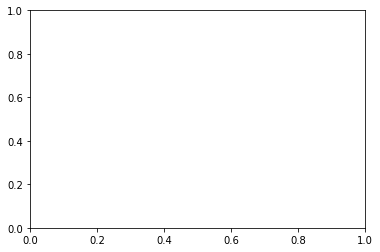

In [ ]:
from lifelines.calibration import survival_probability_calibration

survival_probability_calibration(cph, trainData, t0=100)